<a href="https://colab.research.google.com/github/wdon021/From_Colab/blob/master/Assignment4_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
def create_circle_random(size = 28, radius = 5, color = 255):
  k = np.random.random_sample(size=2)
  col_random = np.int(16*k[0])+6
  row_random = np.int(16*k[1])+6
  data = np.zeros((size, size), dtype = np.uint8)
  ci,cj = row_random, col_random
  cr = radius
  if(((col_random+cr)>=28) | ((col_random-cr)<1)):
    print("col_random is out of bound")
  if(((row_random+cr)>=28) | ((row_random-cr)<1)):
    print("row_random is out of bound")
  I,J = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]))
  # basic formula for a circle (x - a)**2 + (y - b)**2 = r**2
  # calculate the radius
  dist = np.sqrt((I-ci)**2 +(J-cj)**2)
  # Assign value of any for those points within radius
  data[np.where(dist<cr)] = color
  # img = im.fromarray(data)
  return data.flatten()

In [4]:
def rect_x_y(height, width):
  k = np.random.random_sample(size=2)
  start_x = np.int(27*k[0])
  start_y = np.int(27*k[1])
  rows = start_x + height 
  cols = start_y + width
  return start_x, start_y, rows, cols

In [5]:
def rect_random(size, color):
  data = np.zeros((size, size), dtype = np.uint8)
  # x1, y1, x2, y2 = 0, 0, 0, 0
  x1, y1, x2, y2 = rect_x_y(4, 8)
  # print([x1, y1, x2, y2 ])
  while((x2 >=28)|(y2 >=28)):
    x1, y1, x2, y2 = rect_x_y(4, 8)
  # print([x1, y1, x2, y2 ])
  data[x1:x2, y1:y2] = color
  # img = im.fromarray(data)
  return data.flatten()
  # return img

In [6]:
def triang_ran(size, color, diagonals = -1):
  data = np.zeros((size, size), dtype = np.uint8)
  # define a rectangle
  start_x, start_y, rows, cols = rect_x_y(8, 8)
  # print([start_x, start_y, rows, cols])
  while((rows >=28)|(cols >=28)):
    start_x, start_y, rows, cols = rect_x_y(8, 8)
  # print([start_x, start_y, rows, cols])
  data[start_x:rows, start_y:cols] = color
  # return lower triangle of rectangle
  data[start_x:rows, start_y:cols] = np.tril(data[start_x:rows, start_y:cols], diagonals)
  # return upper half triangle of rectangle
  # data[start_x:rows, start_y:cols] = np.triu(data[start_x:rows, start_y:cols], diagonals)
  # img = im.fromarray(data)
  # return img
  return data.flatten()

In [7]:
def random_shape():
  data = np.array([])
  name = ""
  prob = np.random.random_sample()
  if(prob<= 0.33333333333333333):
    data = create_circle_random(28, 5, 255)
    name = "C"
  elif((prob> 0.33333333333333333) & (prob<= 0.66666666666666666)):
    data = rect_random(28, 255)
    name = "R"
  else:
    data = triang_ran(28, 255)
    name = 'T'
  return data, name

In [8]:
def random_generate(size):
  shape_vect = []
  shape_name = []
  for i in range(size):
    s_vect, s_name = random_shape()
    shape_vect.append(s_vect)
    shape_name.append(s_name)
  num_2d_shape = np.array(shape_vect).reshape(-1, 784)
  return num_2d_shape, shape_name

In [9]:
train_shape, train_name =  random_generate(60000) 
# before is 3,000 now try 30,000
# now try 60,000 after 30,000

Data transform

In [10]:
train_shape_N = train_shape/255.0

In [11]:
train_shape_R = train_shape_N.reshape(-1, 28, 28, 1)

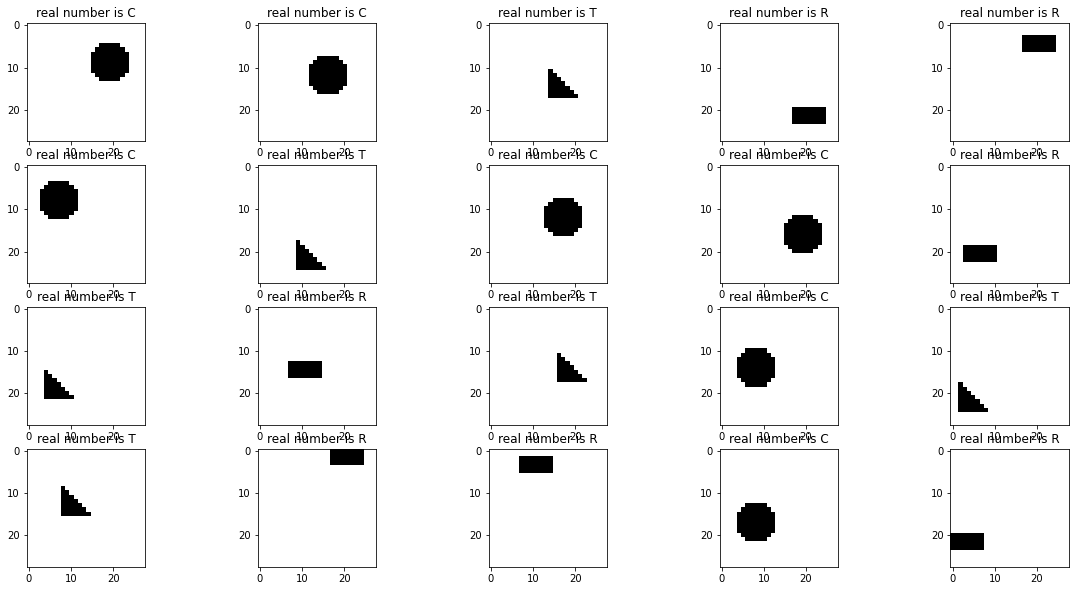

In [12]:
train_shape1, train_name1 =  random_generate(size = 20)
train_shape__ = train_shape1.reshape(train_shape1.shape[0], 28, 28)
fig, axis = plt.subplots(4, 5, figsize = (20, 10))
for i, ax in enumerate(axis.flat):
  ax.imshow(train_shape__[i], cmap = 'binary')
  # digit = y_train[i].argmax()
  ax.set(title = f"real number is {train_name1[i]}")

### Generate N(0,I) for encoder output z_vector to approximate

In [13]:
mean = [0, 0]
cov = [[1, 0],
       [0, 1]]
MVN = np.random.multivariate_normal(mean, cov, 1000)

In [14]:
MVN2 = np.random.multivariate_normal(mean, cov, 1000)

Maximum mean discrepancy

In [15]:
@tf.function
def different_kernel(X,Y, lamb):
  z1 = tf.expand_dims(X, 0)
  z2 = tf.expand_dims(Y, 1)
  print("different kernel")
  return (tf.reduce_sum(tf.exp(-tf.reduce_sum(tf.math.squared_difference(z1, z2),axis= -1)/lamb)))/(len(X)*(len(Y)))

In [16]:
@tf.function
def same_kernels(X, lamb):
  z1 = tf.expand_dims(X, 0)
  z2 = tf.expand_dims(X, 1)
  print("same_kernels")
  return (tf.reduce_sum(tf.exp(-tf.reduce_sum(tf.math.squared_difference(z1, z2),axis= -1)/lamb))-len(X))/(len(X)*(len(X)-1))

In [17]:
@tf.function
def MMD(X, Y, lam):
  X = tf.cast(X, dtype=tf.float32)
  Y = tf.cast(Y, dtype=tf.float32)
  return same_kernels(X, lam)+same_kernels(Y, lam)-(2*(different_kernel(X, Y, lam)))

Building the encoder

slice the dataset

In [ ]:
class Plus(layers.Layer):
  def call(self, inputs):
    z_vector = inputs
    batch = tf.shape(z_vector)[0]
    dim = tf.shape(z_vector)[1]
    eps = tf.keras.backend.random_normal(shape = (batch, dim))
    return eps+z_vector

In [31]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation = 'relu', strides = 2, padding = 'same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation = 'relu', strides = 2, padding = 'same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation= 'relu')(x)
z = layers.Dense(latent_dim, name = 'z_vector')(x)
# w = Plus()([z])
encoder = keras.Model(encoder_inputs, z, name ='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                50192     
_________________________________________________________________
z_vector (Dense)             (None, 2)                 34        
Total params: 69,042
Trainable params: 69,042
Non-trainable params: 0
_______________________________________________________

build the decoder

In [30]:
latent_input = keras.Input(shape = (latent_dim,))
x = layers.Dense(7*7*64, activation='relu')(latent_input)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Convolution2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder = keras.Model(latent_input, decoder_outputs, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [68]:
class GVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(GVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
         layers.InputLayer(input_shape=(28, 28, 1)),
         layers.Conv2D(32, 3, activation = 'relu', strides = 2, padding = 'same'),
         layers.Conv2D(64, 3, activation = 'relu', strides = 2, padding = 'same'),
         layers.Flatten(),
         layers.Dense(16, activation= 'relu'),
         layers.Dense(latent_dim, name = 'z_vector'),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
         layers.InputLayer(input_shape = (latent_dim,)),
         layers.Dense(7*7*64, activation= 'relu'),
         layers.Reshape((7, 7, 64)),
         layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
         layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same'),
         layers.Convolution2DTranspose(1, 3, activation='sigmoid', padding='same'),
        ]
    )
  def addnoise(self, mean, stdv):
    eps = stdv*tf.random.normal(shape = mean.shape)
    return eps+mean

In [71]:
epochs = 100
batch_sizes = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_shape_R)
train_dataset = train_dataset.shuffle(buffer_size=60000).batch(batch_sizes)
optimizer = tf.keras.optimizers.Adam(1e-3)

In [72]:
gvae = GVAE(2)
for epoch in range(epochs):
  print("\n=================start of epoch %d" %(epoch,))
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      # print("x_batch_train shape:", x_batch_train.shape)
      z_vector = gvae.encoder(x_batch_train)
      # print("z_vector shape:", z_vector.shape)
      # eps = tf.random.normal(shape = z_vector.shape)
      w_vector = gvae.addnoise(z_vector, 0.1)
      reconstruction = gvae.decoder(w_vector)
      reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x_batch_train, reconstruction))
      # print("reconstruction_loss:", reconstruction_loss)
      reconstruction_loss *= 28*28
      maximum_mean_d = MMD(z_vector, MVN, 0.2)
      maximum_mean_d *= 28*28
      # print("maximum_mean_d", maximum_mean_d)
      total_loss = reconstruction_loss + maximum_mean_d
      # print("total_loss:", total_loss)
    grads = tape.gradient(total_loss, gvae.trainable_weights)
    # print(gvae.trainable_weights)
    optimizer.apply_gradients(zip(grads, gvae.trainable_weights))
    # print(gvae.trainable_weights)
  print("Reconstruction error: ", reconstruction_loss)
  print("Maximum_mean_discrepancy: ", maximum_mean_d)
  print("total loss: ", total_loss)


=================start of epoch 0
Reconstruction error:  tf.Tensor(52.107677, shape=(), dtype=float32)
Maximum_mean_discrepancy:  tf.Tensor(1.732931, shape=(), dtype=float32)
total loss:  tf.Tensor(53.840607, shape=(), dtype=float32)

=================start of epoch 1
Reconstruction error:  tf.Tensor(42.0542, shape=(), dtype=float32)
Maximum_mean_discrepancy:  tf.Tensor(0.58407295, shape=(), dtype=float32)
total loss:  tf.Tensor(42.63827, shape=(), dtype=float32)

=================start of epoch 2
Reconstruction error:  tf.Tensor(41.66516, shape=(), dtype=float32)
Maximum_mean_discrepancy:  tf.Tensor(0.14041793, shape=(), dtype=float32)
total loss:  tf.Tensor(41.80558, shape=(), dtype=float32)

=================start of epoch 3
Reconstruction error:  tf.Tensor(37.258923, shape=(), dtype=float32)
Maximum_mean_discrepancy:  tf.Tensor(1.8989979, shape=(), dtype=float32)
total loss:  tf.Tensor(39.15792, shape=(), dtype=float32)

=================start of epoch 4
Reconstruction error:  tf.

In [73]:
zsample = np.array([np.random.random(2)])

In [75]:
construct = gvae.decoder.predict(zsample)

In [86]:
def plot_latent(encoder, decoder):
  n = 10
  digit_size = 28
  scale = 2.0
  figsize = 15
  figure = np.zeros((digit_size * n, digit_size *n))
  grid_x = np.linspace(-scale, scale, n)
  grid_y = np.linspace(-scale, scale, n)[::-1] # reverse sign

  for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
      z_sample = np.array([[xi, yi]])
      x_decoded = decoder.predict(z_sample)
      digit = x_decoded[0].reshape(digit_size, digit_size)
      figure[
             i * digit_size : (i+1) *digit_size,
             j * digit_size : (j+1) *digit_size,
      ] = digit
  plt.figure(figsize=(figsize, figsize))
  start_range = digit_size//2
  end_range = n* digit_size + start_range + 1
  pixel_range = np.arange(start_range, end_range, digit_size)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.imshow(figure, cmap = 'Greys_r')
  plt.show()

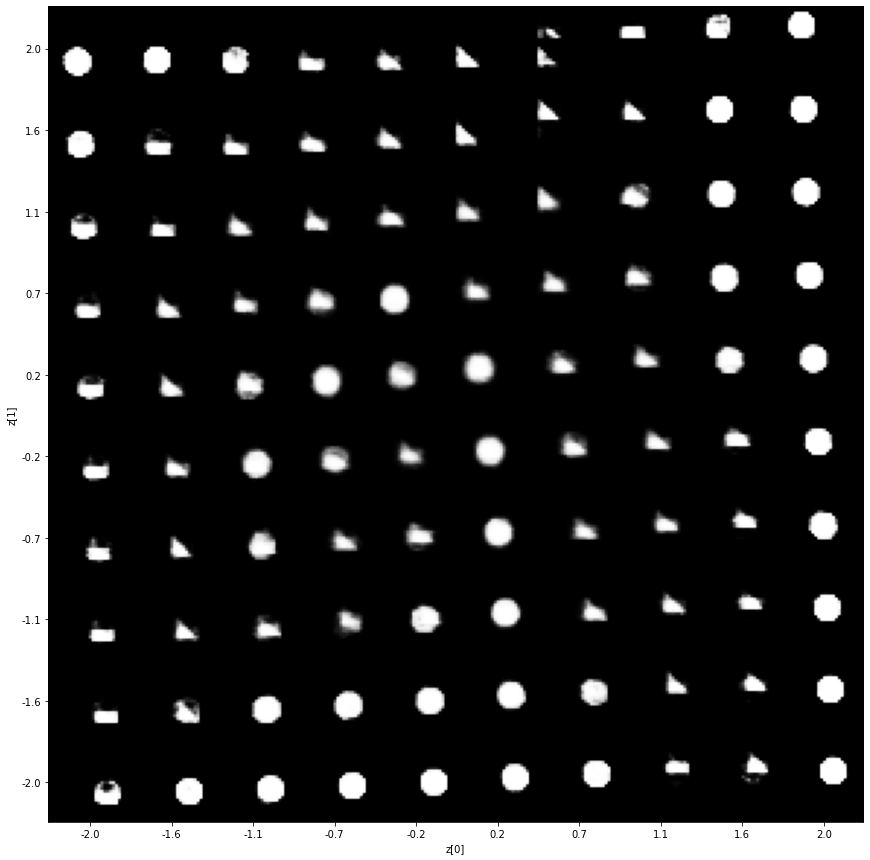

In [87]:
plot_latent(gvae.encoder, gvae.decoder)

In [77]:
digit = construct[0].reshape(28,28)

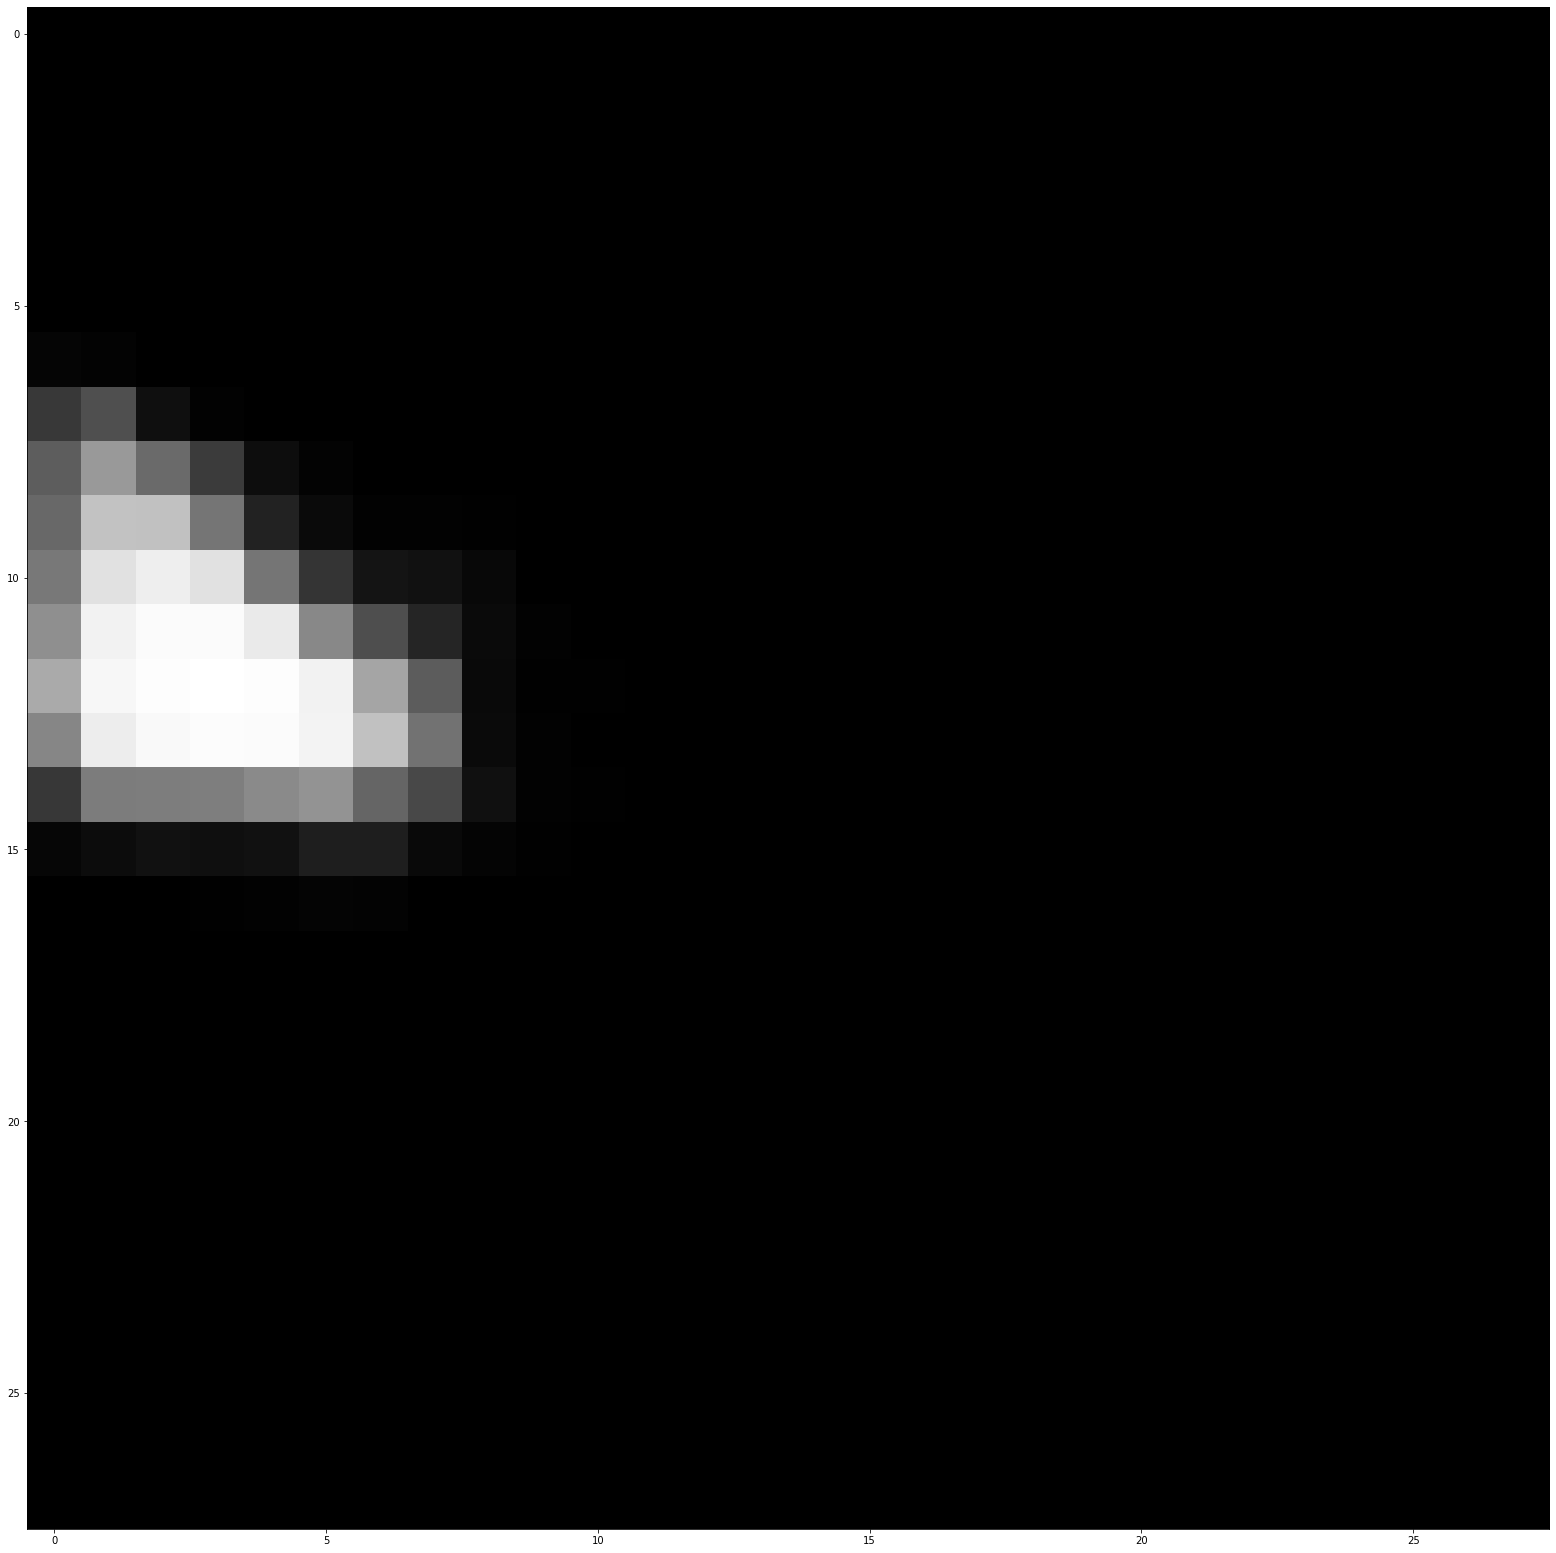

In [80]:
figsize = 28
plt.figure(figsize=(figsize, figsize))
plt.imshow(digit, cmap='Greys_r')
plt.show()

Build the model

In [ ]:
class GVAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(GVAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
  def addnoise(self, z_vector, stdev):
    epsilon = stdev*tf.keras.backend.random_normal()
  def train_step(self, data):
    if isinstance(data, tuple):
      data = data
    with tf.GradientTape() as tape:
      z_vector = encoder(data)
      print("print of z",z_vector.shape[0])
      print("print of z",z_vector.shape[1])
      batch = tf.shape(z_vector)[0]
      dim = tf.shape(z_vector)[1]
      eps = tf.keras.backend.random_normal(shape = (batch, dim))
      print("z value is:", z_vector)
      w = z_vector + eps
      print("w value is:", w)
      reconstruction = decoder(w)
      reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
      reconstruction_loss *= 28*28
      print("reconstruction_loss is:", reconstruction_loss)
      Max_Mean_D = MMD(z_vector, tf.cast(MVN, dtype=tf.float32), lam = 1)
      print("Max_Mean_D:", Max_Mean_D)
      Max_Mean_D *= 28*28
      total_loss = reconstruction_loss + Max_Mean_D
    grads = tape.gradient(reconstruction_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    return{
        'loss': 'total_loss',
        'reconstruction_loss': reconstruction_loss,
        'Maximum_mean_divergence': 'Max_Mean_D'
    }


In [ ]:
gvae = GVAE(encoder, decoder)
gvae.compile(optimizer = keras.optimizers.Adam())
gvae.fit(train_shape_R, epochs = 10, batch_size = 128)

Epoch 1/10
shape of data:  (None, 28, 28, 1)
print of z None
print of z 2
z value is: Tensor("encoder/z_vector/BiasAdd:0", shape=(None, 2), dtype=float32)
w value is: Tensor("add:0", shape=(None, 2), dtype=float32)
reconstruction_loss is: Tensor("mul:0", shape=(), dtype=float32)
same_kernels


TypeError: ignored